In [ ]:
# Python Notebook
# Script to average fast scan STEM image series recorded
#     by TIA preview scans
#
# J. Barthel, Forschungszentrum Juelich GmbH (ER-C 2), Germany
# ju.barthel@fz-juelich.de
#
# 1) load the image series using serReader
# 2) define a ROI for drift measurement
# 3) measure image to image shifts with 1 pixel accuray
# 4) correct image shifts
# 5) sum shift corrected images
# 6) output
#

In [1]:
import numpy as np
from serReader import serReader
from emilys.image.arrayplot import arrayplot2d
from emilys.image.shift import get_rigid_shift
from matplotlib.patches import Rectangle, FancyArrow, Circle
import matplotlib.pyplot as plt
%matplotlib inline

# 1. Input Data

In [2]:
## setup parameters for loading data
ndim = np.array([2048,2048]).astype(int) # image frame dimensions in pixels (v,h)
nfrm = 20 # number of frames in the data
sworkdir = 'F:/Data/Simulation/GdFeO3/KeRan-191125/exp/' # working directory of the script
sfile1 = 'Scanning Preview_1.ser' # file name of data

2D dataset with: 40 image(s)
- scan sampling     : 2048 x 2048
- scan step    [nm] : 0.0030329 x 0.0030329
- scan field   [nm] : 6.2113 x 6.2113


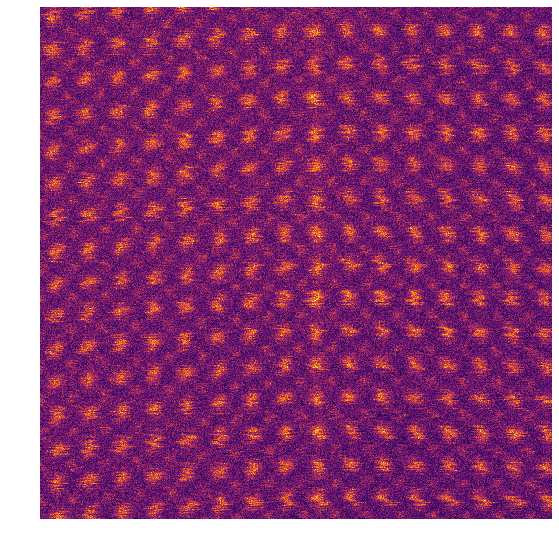

In [3]:
## load the data using the serReader module
ldata1 = serReader(sworkdir + sfile1)
nd = ldata1['data'].shape
nfrm = nd[0] # number of images
ndim = nd[1:3] # image dimension
samp_x = ldata1['pixelSizeX'] *1.E9 # x-scan step in nm
samp_y = ldata1['pixelSizeY'] *1.E9 # y-scan step in nm
data_type = ldata1['data'].dtype # data type
imgser = ldata1['data'].astype(float) # tranform image data to float type for post-processing
print('- scan sampling     : {:d} x {:d}'.format(ndim[1],ndim[0]))
print('- scan step    [nm] : {:.5G} x {:.5G}'.format(samp_x,samp_y))
print('- scan field   [nm] : {:.5G} x {:.5G}'.format(samp_x * ndim[1],samp_y * ndim[0]))
# show the first frame on quarter size
fig0, ax0 = arrayplot2d(imgser[0], 0.25, 'inferno')

# 2. Select region of interest

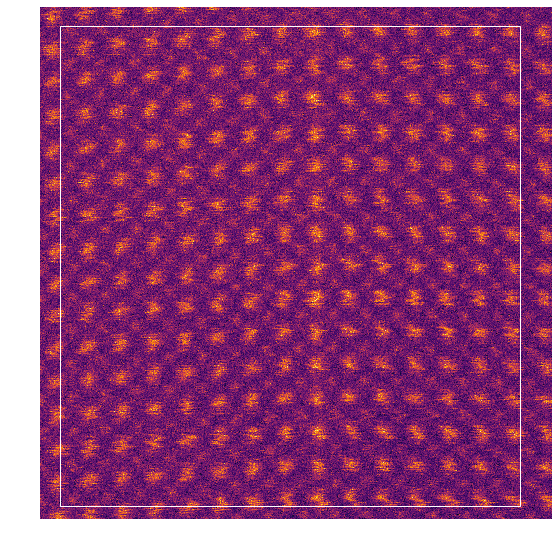

In [7]:
## define the roi
proi0 = np.array([50,80]).astype(int) # ROI offset (bottom, left)
ndimroi = np.array([1920,1840]).astype(int) # ROI size (height, width)
## draw the roi
rectroi = Rectangle(np.flip(proi0), ndimroi[1], ndimroi[0], fill=False, ec='w', fc='none', lw=1.);
fig0, ax0 = arrayplot2d(imgser[0], 0.25, 'inferno')
ax0.add_patch(rectroi);

# 3. Measure image shifts

In [10]:
## measure rigid shifts from the roi
### get data in roi
ldatroi = imgser[:,proi0[0]:proi0[0]+ndimroi[0],proi0[1]:proi0[1]+ndimroi[1]].copy()
mroi0 = np.mean(ldatroi)
sroi0 = np.std(ldatroi)
print('image ROI mean and std. deviation: {:10.3E}, {:10.3E}'.format(mroi0,sroi0))
### get consecutive image shifts
lshift = np.zeros((nfrm,2))
for i in range(1, nfrm):
    lshift[i] = get_rigid_shift(ldatroi[i], ldatroi[i-1], maxshift=10)

image ROI mean and std. deviation:  2.412E+04,  8.267E+03


# 4. Sum images with drift correction

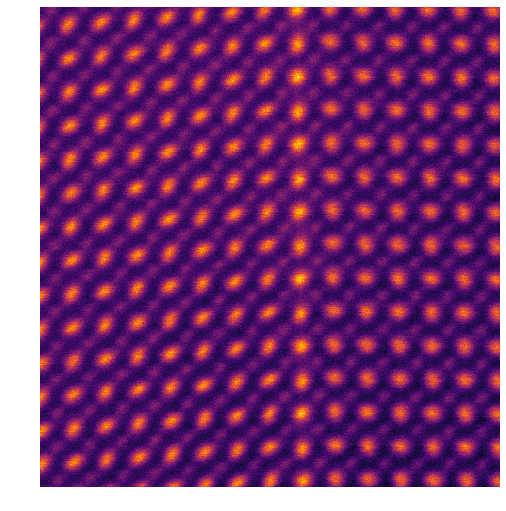

In [17]:
## get data in roi with shift correction - updating ldatroi
ldatroisum = ldatroi[0].copy()
cshift = np.array([0,0])
for l in range(1, nfrm):
    cshift[...] = cshift + lshift[l]
    k0 = int(proi0[0]-cshift[0])
    h0 = int(proi0[1]-cshift[1])
    ldatroisum += np.roll(imgser[l], cshift, axis=(0,1))[proi0[0]:proi0[0]+ndimroi[0],proi0[1]:proi0[1]+ndimroi[1]]
### show the sum image
fig1, ax1 = arrayplot2d(ldatroisum, 0.25, 'inferno')

# 5. Save data and images

- data saved to file: F:/Data/Simulation/GdFeO3/KeRan-191125/exp/avg_GFO_HAADF_TB_1840x1920_float64.dat
- mean and std. deviation:  9.652E+05,  1.671E+05


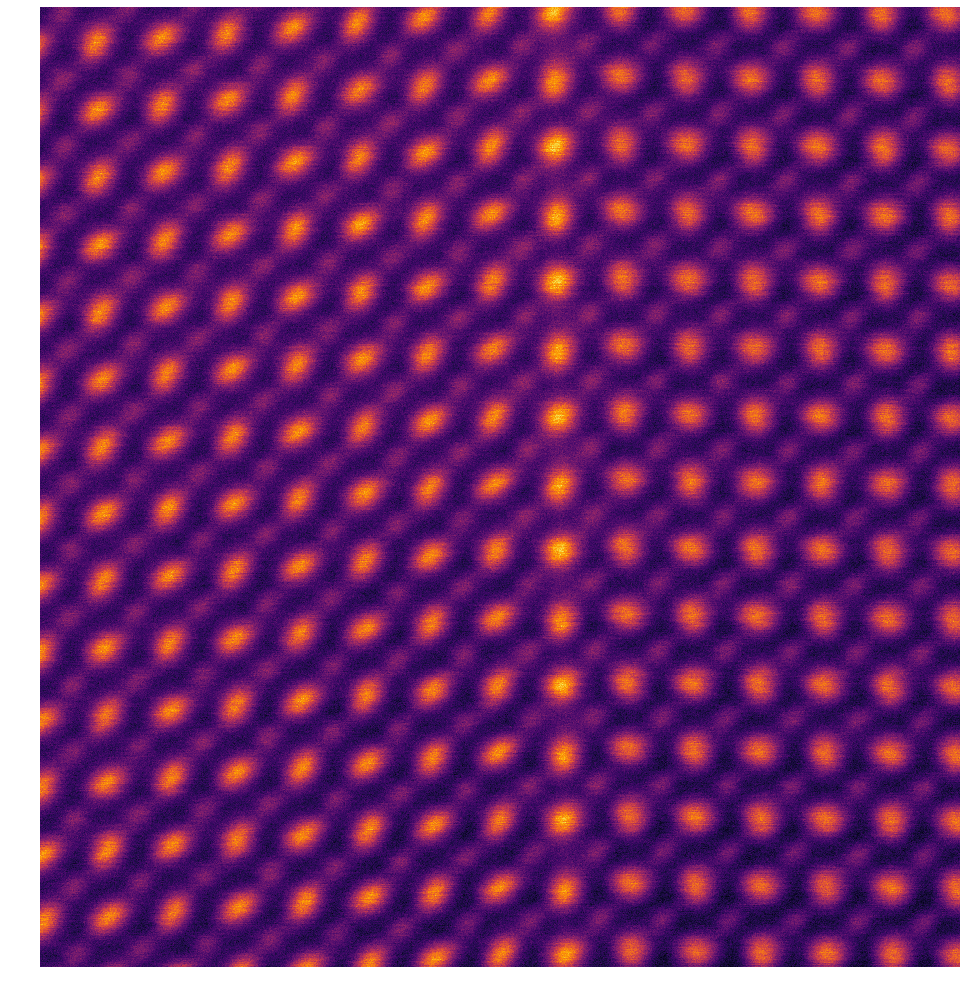

In [19]:
## save the averaged data to disk
def savedatatofile(ldata,sfile): # data save function
    ldatf = ldata.copy()
    nde = ldatf.shape
    sny = '{:d}'.format(nde[0])
    snx = '{:d}'.format(nde[1])
    sfileex = sfile + snx + 'x' + sny +'_float64.dat'
    ldatf.tofile(sfileex)
    print('- data saved to file: ' + sfileex)
    mroi0 = np.mean(ldatf)
    sroi0 = np.std(ldatf)
    print('- mean and std. deviation: {:10.3E}, {:10.3E}'.format(mroi0,sroi0))
### save data
savedatatofile(ldatroisum, sworkdir + 'avg_GFO_HAADF_TB_')
### save image (half size)
fig1r, ax1r = arrayplot2d(ldatroisum, 0.5, 'inferno')
plt.savefig(sworkdir + 'avg_GFO_HAADF_TB.png')